# 02: Training

This notebook loads the data from the previous notebook and trains a model to predict forest attributes. The model is evaluated and saved to disk for later use.

In [58]:
import os
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import wandb
from sklearn.metrics import r2_score

from naip_cnn import models
from naip_cnn.data import NAIPDatasetWrapper
from naip_cnn.inference import predict_image

os.environ["WANDB_NOTEBOOK_NAME"] = "02_train_model.ipynb"
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [59]:
os.environ["WANDB_NOTEBOOK_NAME"] = "02_train_model.ipynb"
wandb.init(project="naip-cnn", group="30m_rh95", config={}, save_code=True)

In [60]:
BANDS = ("R", "G", "B", "N")
LABEL = "rh95"
BATCH_SIZE = 32
DATASET_NAME = "MAL2016_CanyonCreek-1-30-150x150-150"

EPOCHS = 250
PATIENCE = 25
LEARN_RATE = 0.001

## Load Data

Before training, we need load our dataset, split it into training and validation sets, and divide it into batches. The same `TrainingDataset` class we used to generate the dataset can be re-used now for training. All of the parameters we defined when generating our training dataset are stored in the file name, allowing us to load a complete `TrainingDataset` from the file we exported earlier.

Additional parameters like the NAIP bands to include, the LiDAR attribute to predict, and the model batch size are defined separately.

In [61]:
wrapper = NAIPDatasetWrapper.from_filename(DATASET_NAME)

train = (
    wrapper.dataset.load_train(label=LABEL, bands=BANDS)
    .cache()
    .shuffle(buffer_size=10_000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val = (
    wrapper.dataset.load_val(label=LABEL, bands=BANDS)
    .cache()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

## Build and Train Model

With the data loaded, we can build a CNN model and train it. The `ModelRun` class wraps a Keras model and a `TrainingDataset` and is used to organize, identify, and export a given model run.

In [62]:
model = models.CNN_v2(
    shape=(*wrapper.naip_shape, len(BANDS)), out_shape=wrapper.lidar_shape
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss="mse",
    metrics=["mae", "mse"],
)

run = models.ModelRun(
    model=model,
    dataset=wrapper,
    label=LABEL,
    bands=BANDS,
)

While training the model, we'll use two callbacks: 

- `EarlyStopping` interrupts training if loss stops improving after the number of epochs defined by `patience`. This can reduce training time by aborting once a model starts to overfit, when further epochs are unlikely to improve model performance. Lower `patience` values stop the model sooner, but may trigger prematurely due to random fluctuations in loss.
- `ModelCheckpoint` stores the weights of the best performing epoch, allowing us to restore the optimal model if later epochs begin to overfit. 

*Note that while `EarlyStopping` *can* restore weights, this only works if the callback is triggered, which may not happen if `patience` is not exceeded.*

In [63]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", verbose=1, patience=PATIENCE, restore_best_weights=False
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # keras does a second formatting run for the epoch
        filepath=f"../models/.checkpoint_{run.name}_{{epoch:04d}}.h5",
        save_best_only=True,
        save_weights_only=True,
        verbose=False,
        monitor="val_loss",
    ),
    early_stopping,
    wandb.keras.WandbMetricsLogger(),
]

run.model.fit(
    train,
    verbose=1,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/250
465/465 [==============================] - 82s 100ms/step - loss: 56.0405 - mae: 5.7692 - mse: 56.0405 - val_loss: 37.1327 - val_mae: 4.7403 - val_mse: 37.1327
Epoch 2/250
465/465 [==============================] - 9s 19ms/step - loss: 40.3512 - mae: 4.9740 - mse: 40.3512 - val_loss: 35.7032 - val_mae: 4.6321 - val_mse: 35.7032
Epoch 3/250
465/465 [==============================] - 9s 19ms/step - loss: 36.9787 - mae: 4.7581 - mse: 36.9787 - val_loss: 33.9662 - val_mae: 4.5531 - val_mse: 33.9662
Epoch 4/250
465/465 [==============================] - 9s 19ms/step - loss: 33.4334 - mae: 4.5199 - mse: 33.4334 - val_loss: 32.8464 - val_mae: 4.4265 - val_mse: 32.8464
Epoch 5/250
465/465 [==============================] - 9s 19ms/step - loss: 31.4876 - mae: 4.3790 - mse: 31.4876 - val_loss: 32.1894 - val_mae: 4.4396 - val_mse: 32.1894
Epoch 6/250
465/465 [==============================] - 9s 19ms/step - loss: 29.4826 - mae: 4.2328 - mse: 29.4826 - val_loss: 32.0713 - val_mae: 4.38

In [64]:
best_epoch = run.load_best_checkpoint()
stopped_epoch = early_stopping.stopped_epoch if early_stopping else EPOCHS
run.save_model()

PosixPath('../models/CNN_v2-MAL2016_CanyonCreek-1-30-150x150-150-rh95-RGBN.keras')

In [65]:
wandb.log_model(run.model_path)

## Log Parameters

In [66]:
def log_params(
    config: dict,
    *,
    dataset: NAIPDatasetWrapper,
    model_run: models.ModelRun,
    bands: Tuple[str],
    label: str,
    batch_size: int,
    learn_rate: float,
    epochs: int
):
    """Log parameters from a model run to an Aim experiment."""
    config.update(
        {
            "training": {
                "batch_size": batch_size,
                "learning_rate": learn_rate,
                "epochs": epochs,
            },
            "model": {
                "architecture": model_run.model.name,
                "path": model_run.model_path.as_posix(),
            },
            "data": {
                "path": dataset.hdf_path.as_posix(),
                "date": {
                    "start": dataset.acquisition.start_date,
                    "end": dataset.acquisition.end_date,
                },
                "footprint": {
                    "shape": dataset.footprint,
                    "spacing": dataset.spacing,
                },
                "imagery": {
                    "bands": "".join(bands),
                    "resolution": dataset.naip_res,
                    "acquisition": dataset.acquisition.name,
                },
                "lidar": {
                    "label": label,
                    "resolution": dataset.lidar_res,
                    "asset": dataset.acquisition.lidar_asset,
                },
            },
        }
    )

In [67]:
log_params(
    wandb.config,
    dataset=wrapper,
    model_run=run,
    bands=BANDS,
    label=LABEL,
    batch_size=BATCH_SIZE,
    learn_rate=LEARN_RATE,
    epochs=EPOCHS,
)

## Log Metrics

Log the metrics of the final, best model.

In [68]:
y_pred = run.model.predict(val)
y_true = np.concatenate([data[1] for data in val.as_numpy_iterator()])
metric_vals = run.model.evaluate(val)


metrics = {
    "best_epoch": best_epoch,
    "stopped_epoch": stopped_epoch,
    "r2_score": r2_score(y_true.ravel(), y_pred.ravel()),
}

for metric, value in zip(run.model.metrics_names, metric_vals):
    metrics[metric] = value

metrics = {f"final/{k}": v for k, v in metrics.items()}

wandb.run.summary.update(metrics)

58/58 [==============================] - 1s 9ms/step - loss: 31.9355 - mae: 4.3765 - mse: 31.9355


## Log Figures

### Correlation Scatterplot

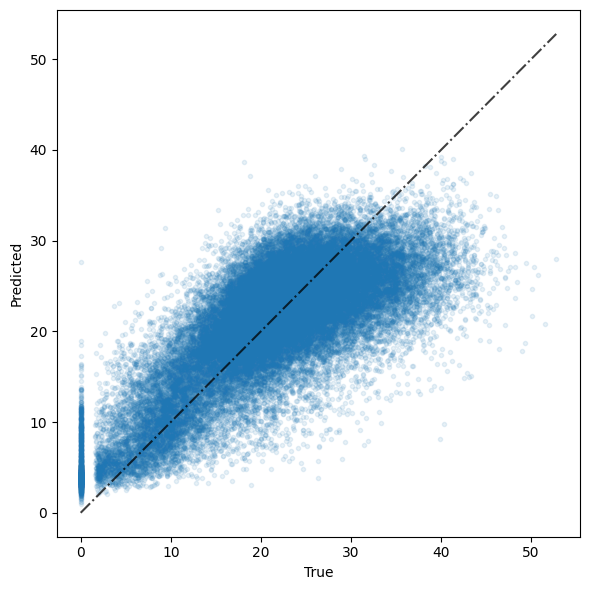

In [69]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_true, y_pred, alpha=0.1, marker=".")
ax.plot((y_true.min(), y_true.max()), (y_true.min(), y_true.max()), "k-.", alpha=0.75)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.tight_layout()

In [70]:
wandb.log({"scatter": wandb.Image(fig)})

### Distribution Histograms

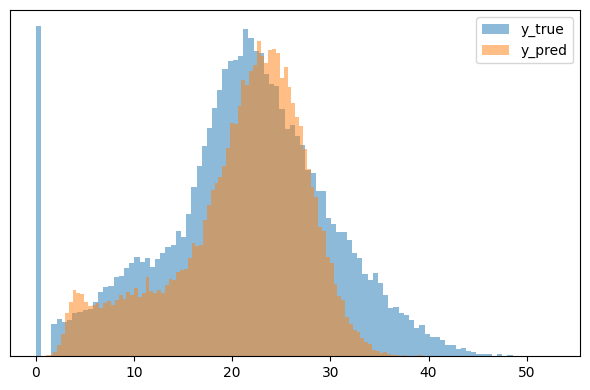

In [71]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(y_true.ravel(), bins=100, alpha=0.5, label="y_true")
ax.hist(y_pred.ravel(), bins=100, alpha=0.5, label="y_pred")
ax.legend()
ax.set_yticks([])
plt.tight_layout()

In [72]:
wandb.log({"hist": wandb.Image(fig)})

### Validation Predictions

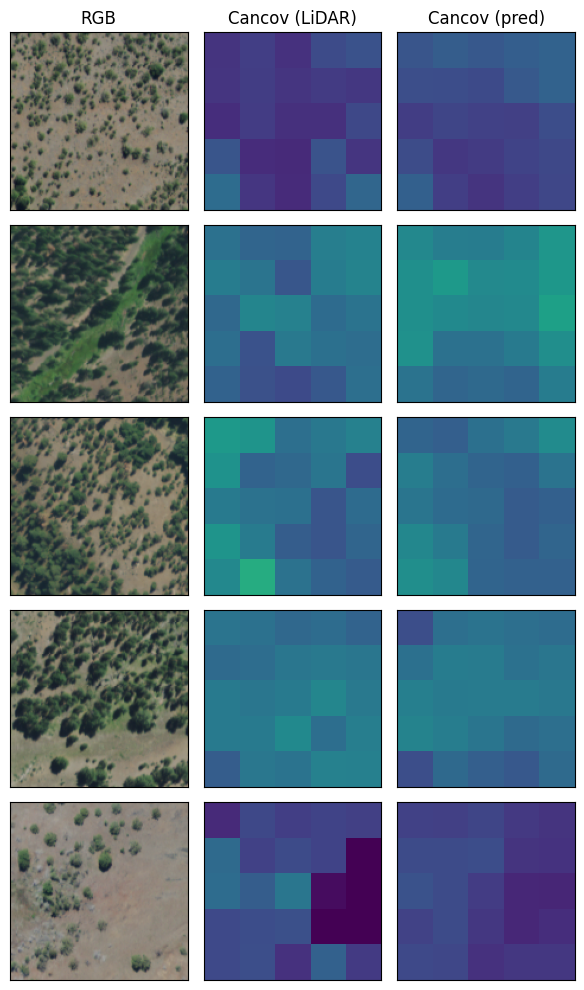

In [73]:
X_ref = np.concatenate([data[0] for data in val.as_numpy_iterator()])
rng = np.random.default_rng(99)
check_samples = rng.choice(range(len(X_ref)), size=5, replace=False)

fig, ax = plt.subplots(len(check_samples), 3, figsize=(6, 2 * len(check_samples)))

for i, sample in enumerate(check_samples):
    ax[i, 0].imshow(X_ref[sample, ..., :3])
    ax[i, 1].imshow(y_true[sample, ...], vmin=y_true.min(), vmax=y_true.max())
    ax[i, 2].imshow(y_pred[sample, ...], vmin=y_true.min(), vmax=y_true.max())

ax[0, 0].set_title("RGB")
ax[0, 1].set_title("Cancov (LiDAR)")
ax[0, 2].set_title("Cancov (pred)")

# Remove ticks
for sub_ax in ax.ravel():
    sub_ax.set_xticks([])
    sub_ax.set_yticks([])

plt.tight_layout()

In [74]:
wandb.log({"validation_chips": wandb.Image(fig)})

## Log Images

Run `python scripts/export_evaluation_naip.py` before running the cell below.

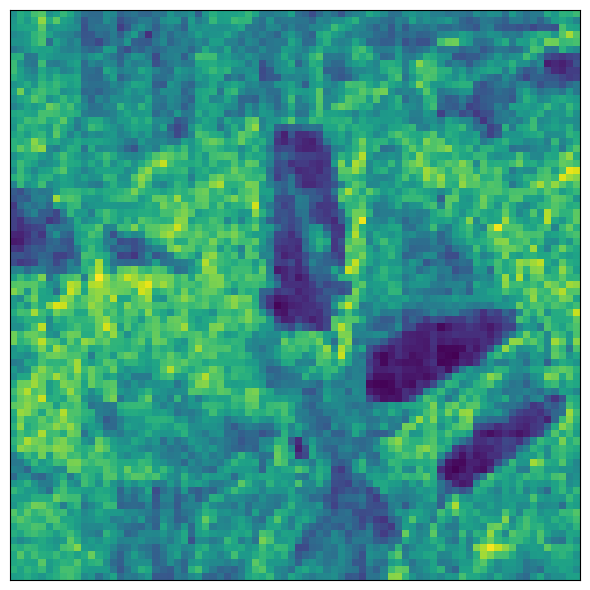

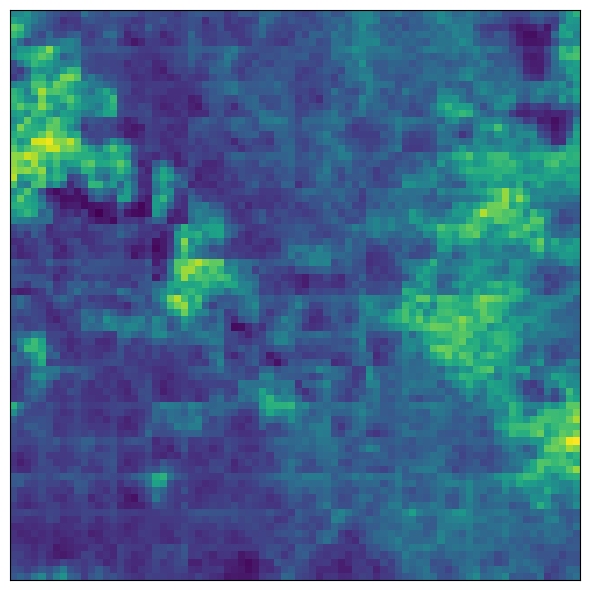

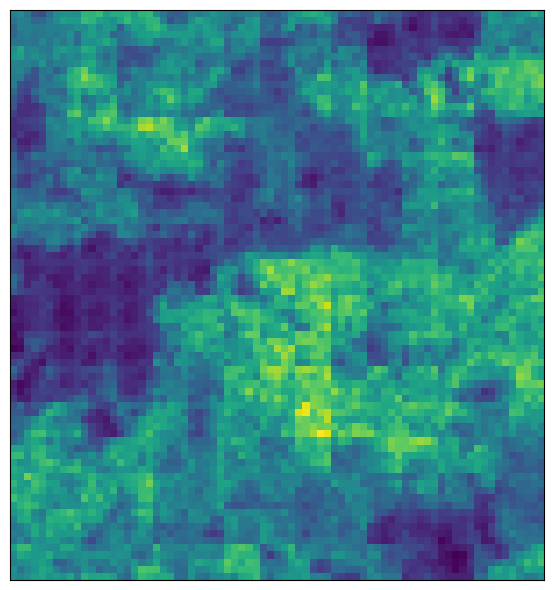

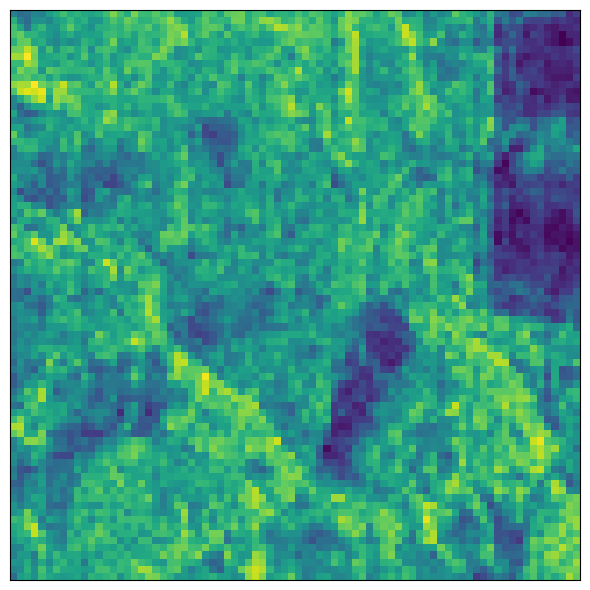

In [75]:
for img_path in Path("../data/naip/").glob("*.tif"):
    pred_img = predict_image(
        img_path=img_path,
        model=run.model,
        in_tile_shape=(*wrapper.naip_shape, len(BANDS)),
        out_tile_shape=wrapper.lidar_shape,
        in_res=wrapper.naip_res,
        out_res=wrapper.lidar_res,
    )

    vis_img = (
        (((pred_img - y_true.min()) / y_true.max()) * 255)
        .clip(0, 255)
        .astype(np.uint8)
        .values
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(vis_img)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    wandb.log({img_path.stem: wandb.Image(fig)})

## Tear Down

In [76]:
wandb.run.finish()

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/mse,█▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▃▂▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇▇██▇████
epoch/val_mae,▃▂▂▁▁▁▁▁▂▂▂▃▄▄▄▄▅▅▆▆▇▇▇▇▇▇█▇████
epoch/val_mse,▃▂▂▁▁▁▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇▇██▇████
epoch/epoch,31
epoch/learning_rate,0.001
epoch/loss,1.54757
